In [1]:
import os
import json
from typing import Any, Type
import numpy as np
import matplotlib.pyplot as plt

from qiskit import Aer, IBMQ, QuantumCircuit, transpile
from qiskit.providers.ibmq.runtime.utils import RuntimeEncoder, RuntimeDecoder
from qiskit.circuit.random import random_circuit
#from qiskit.providers.ibmq.runtime import UserMessenger

from observables import plot_counts_with_curve
from trotter import trotter_step_circuits
from rqd import make_ansatz, FISCPNP, local_cost_function
from rttgen import CNOTBasedRtt
from cx_decomposition import cx_circuit
from model_circuits import single_step, two_steps

In [2]:
backend = Aer.get_backend('qasm_simulator')

kwargs = {
    'num_site': 4,
    'aJ': 1.,
    'am': 0.5,
    'omegadt': 0.2,
    'num_tstep': 8,
    'tstep_per_rqd': 2,
    'error_matrix': np.eye(4, dtype='f8'),
    'maxfuncall': 100
}

In [3]:
num_site = kwargs['num_site']
#aJ = kwargs['aJ']
#am = kwargs['am']
aJ = np.random.rand() * 2.
am = np.random.rand() * 2.
omegadt = kwargs['omegadt']
num_tstep = kwargs['num_tstep']

In [4]:
def make_step_circuits(num_site, aJ, am, omegadt, backend, physical_qubits):
    qubit_pairs = list(zip(range(0, num_site - 1), range(1, num_site)))
  
    if backend.configuration().simulator:
        rtts = dict((qubits, CNOTBasedRtt(backend, qubits)) for qubits in qubit_pairs)
        cxs = dict((qubits, cx_circuit(backend, *qubits)) for qubits in qubit_pairs)
        cxs.update((qubits[::-1], cx_circuit(backend, *qubits[::-1])) for qubits in qubit_pairs)
    else:
        rtts = dict((qubits, PulseEfficientCR(backend, (physical_qubits[qubits[0]], physical_qubits[qubits[1]]))) for qubits in qubit_pairs)
        cxs = dict((qubits, cx_circuit(backend, physical_qubits[qubits[0]], physical_qubits[qubits[1]])) for qubits in qubit_pairs)
        cxs.update((qubits[::-1], cx_circuit(backend, physical_qubits[qubits[1]], physical_qubits[qubits[0]])) for qubits in qubit_pairs)

    single_step_circuit = single_step(num_site, aJ, am, omegadt, rtts=rtts, cxs=cxs)
    two_step_circuit = two_steps(num_site, aJ, am, omegadt, rtts=rtts, cxs=cxs)
    
    return single_step_circuit, two_step_circuit

In [5]:
physical_qubits = kwargs.get('physical_qubits', None)

single_step_circuit, two_step_circuit = make_step_circuits(num_site, aJ, am, omegadt, backend, physical_qubits)

initial_state = QuantumCircuit(4)
initial_state.x(0)
#initial_state.x(1)
initial_state.x(2)
target_circuits = trotter_step_circuits(num_tstep, single_step_circuit, two_step_circuit, initial_state=initial_state, measure=False)

In [6]:
target_circuit = target_circuits[1]
ansatz, params = make_ansatz(2, num_site, num_site // 2, False)
#ansatz, params = make_ansatz(num_site // 2, num_site, num_site // 2, False)
fiscpnp = FISCPNP(target_circuit, (ansatz, params), 0., backend, physical_qubits=physical_qubits, shots=8192, num_experiments=8)

### Circuit synthesis

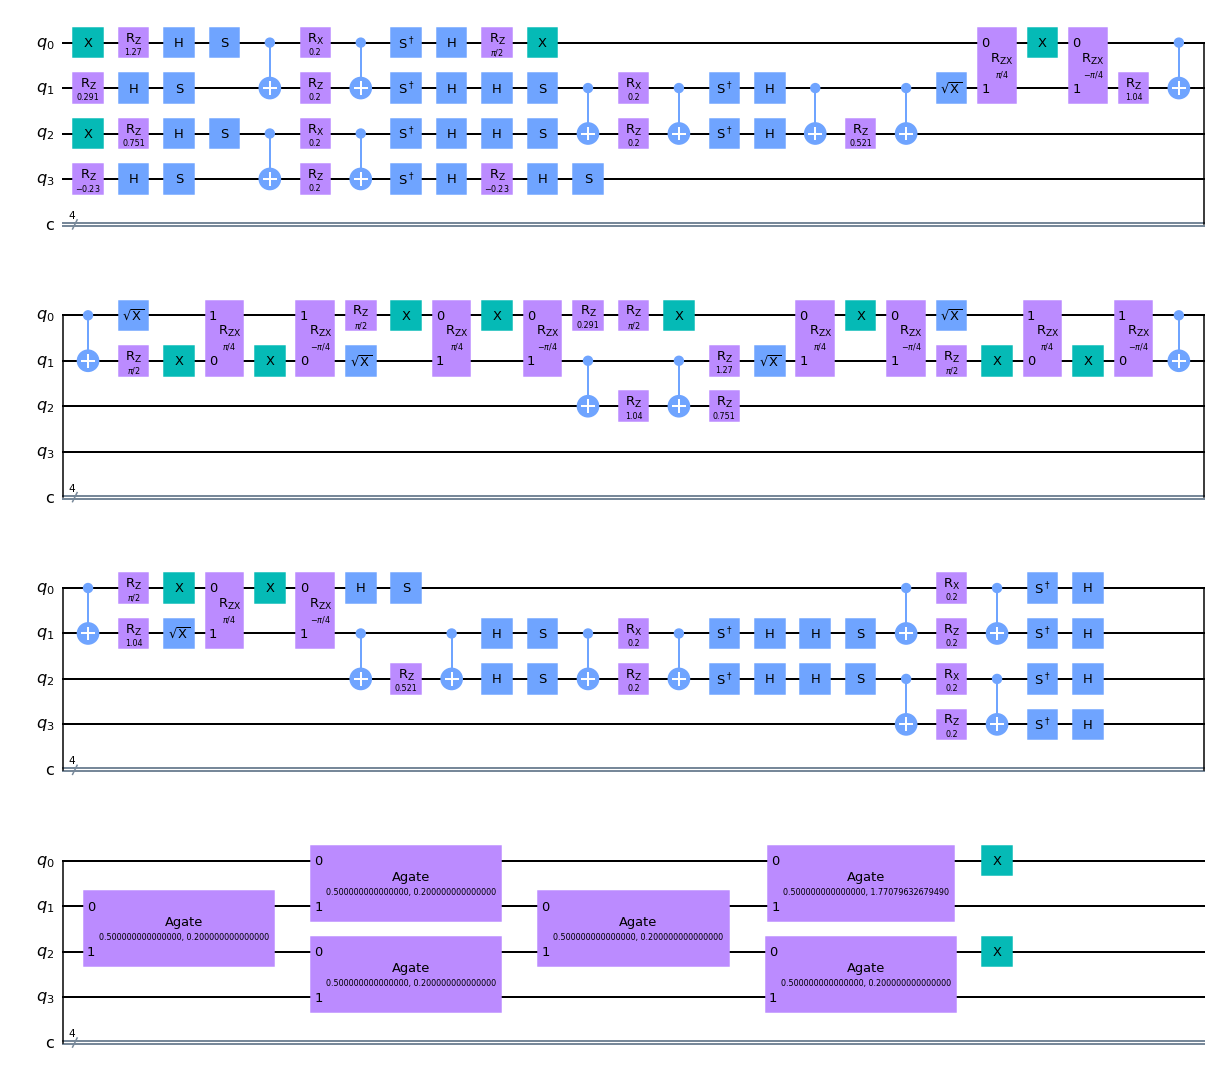

In [7]:
param_val = np.array([0.5, 0.2] * 6)
test_circuit = fiscpnp._make_circuit(param_val, 1, np.pi / 2.)
test_circuit.draw('mpl')

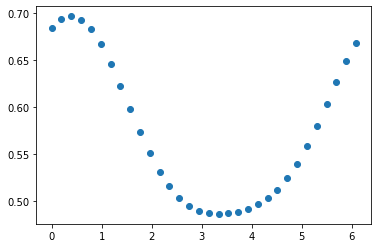

In [14]:
param_values = np.random.rand(12) * 2. * np.pi
simulator = Aer.get_backend('statevector_simulator')

thetas = np.linspace(0., 2. * np.pi, 32, endpoint=False)
costs = np.empty_like(thetas)
for itheta, theta in enumerate(thetas):
    param_values[7] = theta
    circuit = fiscpnp.qc_learning.bind_parameters(dict(zip(params, param_values)))
    circuit = transpile(circuit, backend=simulator)
    sv = simulator.run(circuit).result().data()['statevector']
    probs = np.square(np.abs(sv))
    costs[itheta] = local_cost_function(probs)
    
plt.scatter(thetas, costs)

In [13]:
cos2 = np.cos(thetas * 2.)
sin2 = np.sin(thetas * 2.)

print(np.sum(costs * np.cos(thetas)))
print(np.sum(costs * np.sin(thetas)))
print(np.sum(costs * cos2))
print(np.sum(costs * sin2))

0.3530568867025041
0.28885111370387434
-0.42415038907948976
0.13132075885039718


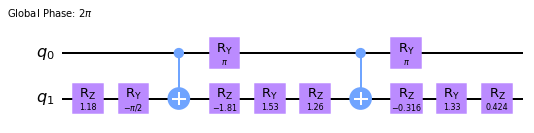

In [10]:
from qiskit.circuit import Parameter
theta = Parameter('theta')
phi = Parameter('phi')
circ = QuantumCircuit(2)
circ.crz(np.pi / 6., 0, 1)
circ.cry(-np.pi / 4., 0, 1)
circ.crz(-np.pi / 6., 0, 1)

transpile(circ, basis_gates=['id', 'rx', 'ry', 'rz', 'cx'], optimization_level=3).draw('mpl')